In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import random

In [2]:
# Setting hyperparameters
n_iters = 299969
learning_rate = 0.001
lr_decay = False
hidden_size = 128
num_layers = 1

In [3]:
# format of the data has to be changed, we dont use batches as data has to be fed sequentially in encoder decoder.

In [4]:
from google.colab import drive
drive.mount('/content/drive')


path = 'drive/MyDrive/Code/Dataset/bitcoin_data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'

Mounted at /content/drive


In [5]:
df1 = pd.read_csv(path)

# df = df1.dropna(how="any")

print(df1.shape)
df1.isnull().sum()

(4857377, 8)


Timestamp                  0
Open                 1243608
High                 1243608
Low                  1243608
Close                1243608
Volume_(BTC)         1243608
Volume_(Currency)    1243608
Weighted_Price       1243608
dtype: int64

In [6]:
df1['Volume_(BTC)'].fillna(value=0, inplace=True)
df1['Volume_(Currency)'].fillna(value=0, inplace=True)
df1['Weighted_Price'].fillna(value=0, inplace=True)

# next we need to fix the OHLC (open high low close) data which is a continuous timeseries so
# lets fill forwards those values...
df1['Open'].fillna(method='ffill', inplace=True)
df1['High'].fillna(method='ffill', inplace=True)
df1['Low'].fillna(method='ffill', inplace=True)
df1['Close'].fillna(method='ffill', inplace=True)

print(df1.shape)
df1.isnull().sum()

(4857377, 8)


Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [7]:
# Generating dataset

def generate_data(X, window, horizon=0):
  features = []
  y = []
  for i in range(0, len(X)-window-1-horizon):
    features.append(X[i:window+i])
    y.append(X[window+i: window+i+horizon])
  return np.array(features), np.array(y)

In [8]:
scaler = MinMaxScaler()
scaler.fit(df1["Weighted_Price"].to_numpy().reshape(-1, 1))
data = scaler.transform(df1["Weighted_Price"].to_numpy().reshape(-1, 1))

In [9]:
X, y = generate_data(data[3000000:3300000, ], 10, 4)

In [10]:
X.shape

(299985, 10, 1)

In [11]:
y.shape

(299985, 4, 1)

In [12]:
y[0]

array([[0.06128692],
       [0.06127006],
       [0.06122708],
       [0.06113907]])

In [13]:
X_test, y_test = generate_data(data[3300000:3350000, ], 10, 4)

In [14]:
print(X_test.shape, y_test.shape)

(49985, 10, 1) (49985, 4, 1)


In [15]:
class EncoderRNN(nn.Module):
    def __init__(self, seq_len, input_size, hidden_size, num_layers):
        super(EncoderRNN, self).__init__()
        self.num_layers = num_layers
        self.seq_len = seq_len
        self.n_features = input_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers)

    def forward(self, input, hidden):
        # hidden = torch.zeros([self.num_layers, self.hidden]).cuda()
        # input = input.reshape([self.seq_len, 1, self.n_features])
        input = input.unsqueeze(2)
        output, hidden = self.gru(input, hidden)
        return output, hidden

In [16]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        # hidden = torch.zeros(1, 1, self.hidden_size, device=device)
        input = input.reshape((1,1,1))
        # print(input.dtype, hidden.dtype)
        output, hidden = self.gru(input, hidden)
        output = self.linear(output)
        return output, hidden

In [17]:
window = 5
horizon_target = 1

seq_length = window
input_shape = 1
encoder = EncoderRNN(seq_length, input_shape, hidden_size, num_layers)

output_shape = 1
decoder = DecoderRNN(input_shape, output_shape, hidden_size, num_layers)

teacher_forcing_ratio = 0.5

In [18]:
# For now the taarget prediction is 4 time steps, we are asking the decoder
# to predict one by one till it predicts for 4 time steps.

In [19]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.shape[0] # 5
    # length of input sentence
    target_length = target_tensor.shape[0] # 4
    # length of target sentence for training

    loss = 0
    encoder_hidden = torch.zeros(num_layers*1, 1, hidden_size)
    encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

    decoder_input = target_tensor[0] # array([0.])

    # Initialized by encoder hidden state, not random initialization.
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input.float(), decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            # loss += criterion(decoder_output.argmax(1), target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input.float(), decoder_hidden)
            # topv, topi = decoder_output.topk(1)
            best_guess = decoder_output.argmax(1)
            # decoder_input = topi.squeeze().detach()  # detach from history as input
            decoder_input = best_guess.detach()

            loss += criterion(decoder_output, target_tensor[di])
            # loss += criterion(best_guess, target_tensor[di])

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item()

In [20]:
print_every=5000
plot_every=10000

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    for iter in range(1, n_iters + 1):
        input_tensor = X[iter - 1]
        target_tensor = y[iter - 1]
        feature = torch.Tensor(input_tensor)
        Y = torch.Tensor(target_tensor).squeeze()

        loss = train(feature, Y, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f"iteration: {iter} and loss: {print_loss_avg}")

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(plot_losses)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


iteration: 5000 and loss: 0.000504310788429717
iteration: 10000 and loss: 0.0006623303395710205
iteration: 15000 and loss: 0.0004382990136621485
iteration: 20000 and loss: 0.0010572693918156073
iteration: 25000 and loss: 0.0010049524732686779
iteration: 30000 and loss: 0.001662472013826153
iteration: 35000 and loss: 0.0009628439215571067
iteration: 40000 and loss: 0.0008099227427125537
iteration: 45000 and loss: 0.0010580437018959062
iteration: 50000 and loss: 0.0006733814957711952
iteration: 55000 and loss: 0.0010445603479974678
iteration: 60000 and loss: 0.0018154556298009283
iteration: 65000 and loss: 0.0007466955993292551
iteration: 70000 and loss: 0.0013025786553341114
iteration: 75000 and loss: 0.000220615498935312
iteration: 80000 and loss: 0.000746224617643867
iteration: 85000 and loss: 0.0006855503359119277
iteration: 90000 and loss: 0.001624472536784964
iteration: 95000 and loss: 0.0011353643731310146
iteration: 100000 and loss: 0.0009127658033258138
iteration: 105000 and los

<Figure size 640x480 with 0 Axes>

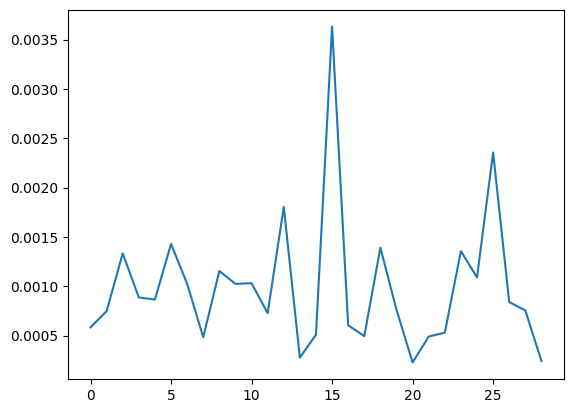

In [21]:
trainIters(encoder, decoder, n_iters=n_iters, plot_every=plot_every, print_every=print_every)

1148588.8789290236 663.7382470317168


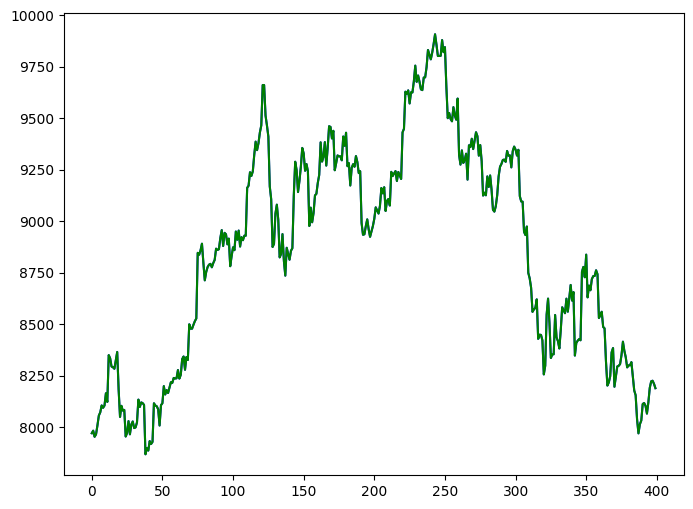

In [22]:
with torch.no_grad():
  preds = []
  true = []
  for iter in range(1, X_test.shape[0] + 1):
  # for iter in range(1, 50):
    input_tensor = X_test[iter - 1]
    target_tensor = y_test[iter - 1]
    true.extend(scaler.inverse_transform(target_tensor))
    feature = torch.Tensor(input_tensor)
    Y = torch.Tensor(target_tensor).squeeze()
    encoder_hidden = torch.zeros(num_layers*1, 1, hidden_size)

    encoder_output, encoder_hidden = encoder(feature, encoder_hidden)

    decoder_input = Y[0]
    preds.append(scaler.inverse_transform(decoder_input.reshape(1, -1)))
    decoder_hidden = encoder_hidden

    for di in range(len(target_tensor)-1):
      decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
      best_guess = decoder_output
      preds.append(scaler.inverse_transform(best_guess.reshape(1, -1)))
      decoder_input = best_guess

  preds = np.concatenate(preds)
  true = np.concatenate(true)
  mse = mean_squared_error(true, preds.squeeze())
  mae = mean_absolute_error(true, preds.squeeze())

  print(mse, mae)
  n = 500
  plt.figure(figsize=(8, 6))
  plt.plot(preds[::n], 'b', label='line 1')
  plt.plot(true[::n], 'g',  label='line 2')
  plt.show()


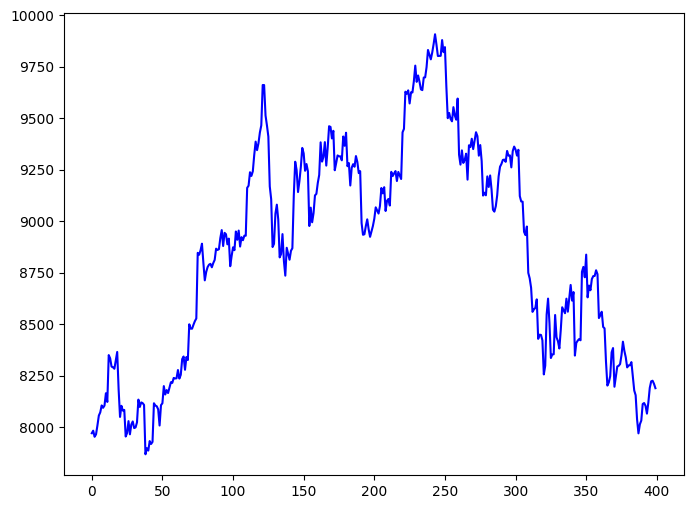

In [23]:
n = 500
plt.figure(figsize=(8, 6))
plt.plot(preds[::n], 'b', label='line 1')
# plt.plot(true[::n], 'g',  label='line 2')
plt.show()